In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
#df_mel['Primary Site - labeled'].unique()

In [2]:
df = pd.read_csv('data_revised_w_cris.csv', engine='python', error_bad_lines=False)

In [3]:
#for strat, data in df_mel.groupby(['Primary Site - labeled', 'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)']):
#    print(f'Looking at variable {strat} with size {len(data)}')
#df['ICD-O-3 Hist/behav'].unique()

### Inclusion criteria

In [4]:
### Make it malignant melanoma only
df_mel = df[df['ICD-O-3 Hist/behav']=='8720/3: Malignant melanoma, NOS']

### Make it Melanoma of the skin only
df_inclusion = df_mel[df_mel['Primary Site - labeled'].str.startswith('C44')]

### Change Blank(s) to NaNs
df_inclusion_w_nans = df_inclusion.replace('Blank(s)', pd.np.nan)

### Drop all NaNs outside the 2004-2015 interval
df_window = df_inclusion_w_nans.dropna(subset=['CS tumor size (2004-2015)'])

df_window.shape

/tmp/ipykernel_2122025/1574326366.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df_inclusion_w_nans = df_inclusion.replace('Blank(s)', pd.np.nan)


(117608, 23)

In [5]:
df_inclusion['Derived AJCC T, 6th ed (2004-2015)'].unique()

df_inclusion[df_inclusion['Derived AJCC T, 6th ed (2004-2015)']=='T0']['CS extension (2004-2015)'].unique()

array(['950'], dtype=object)

### Exclusion criteria

In [6]:
df_window['CS tumor size (2004-2015)'] = df_window['CS tumor size (2004-2015)'].astype(int)
df_exclusion = df_window[ (df_window['CS tumor size (2004-2015)']<990)]

### Values with 999 are of unknown extension and values of 950 state that there is no evidence of primary tumour 
### https://staging.seer.cancer.gov/cs/input/02.05.50/merkel_cell_skin/extension/?version=/tnm/home/1.5/
df_exclusion = df_exclusion[df_exclusion['CS extension (2004-2015)'].astype(int) <960]

### As stated in the article https://www.frontiersin.org/articles/10.3389/fmed.2023.1165865/full
### We exclude patients with no surgery
df_exclusion= df_exclusion[df_exclusion['Reason no cancer-directed surgery']=='Surgery performed']

df_exclusion.to_csv('data_seer_publication.csv' , index=False)
df_exclusion.shape

/tmp/ipykernel_2122025/1072989789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['CS tumor size (2004-2015)'] = df_window['CS tumor size (2004-2015)'].astype(int)


(34929, 23)

### Final data

In [7]:
df_final = pd.read_csv('data_seer_publication.csv')
df_coded = pd.DataFrame()
df_final['Derived AJCC T, 6th ed (2004-2015)'].unique()

array(['T4b', 'T1a', 'T1NOS', 'TX', 'T2a', 'T3a', 'T1b', 'T0', 'T2NOS',
       'T2b', 'T4a', 'T3b', 'T4NOS', 'T3NOS'], dtype=object)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# example data
X = df_final
y = np.zeros(len(df_final))

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train.to_csv('xai_train_data.csv', index=False)
X_test.to_csv('xai_test_data.csv', index=False)
# print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_test['Radiation recode'].value_counts()

X_train shape: (24450, 23)
X_test shape: (10479, 23)
y_train shape: (24450,)
y_test shape: (10479,)


None/Unknown                                             10284
Beam radiation                                             165
Recommended, unknown if administered                        13
Refused (1988+)                                             10
Radioactive implants (includes brachytherapy) (1988+)        3
Radiation, NOS  method or source not specified               2
Radioisotopes (1988+)                                        1
Combination of beam with implants or isotopes                1
Name: Radiation recode, dtype: int64

In [169]:
var = 'Median household income inflation adj to 2021'
df_final[var].value_counts()

$75,000+                                  17492
$65,000 - $69,999                          4555
$70,000 - $74,999                          4257
$60,000 - $64,999                          2766
$55,000 - $59,999                          1923
$50,000 - $54,999                          1640
$45,000 - $49,999                          1074
$40,000 - $44,999                           555
$35,000 - $39,999                           302
< $35,000                                   169
Unknown/missing/no match/Not 1990-2021        1
Name: Median household income inflation adj to 2021, dtype: int64

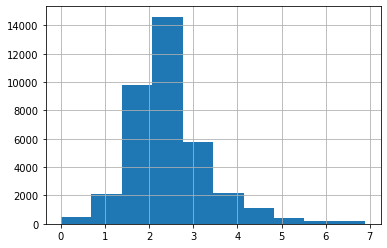

In [134]:
### Age
df_final['Age recode with single ages and 90+'].iloc[0][:2]
df_coded['Age_coded'] = [int(x[:2]) for x in df_final['Age recode with single ages and 90+']]

### Tumor size
df_coded['Tumor size coded'] = df_final['CS tumor size (2004-2015)'].apply(np.log).hist()

### Tumor extension -> Coded as OHE
### RX Summ--Surg Prim Site (1998+) -> convert to int

### Sex binary variable

### Race -> Categorical variable

### Marital status -> OHE TBD how to combine them

### Primary Site - labeled -> OHE with the classes being HF, trunk and limbs

### TNM -> OHE

### Summary stage 2000 (1998-2017) -> Ordinal variable or OHE

### Radiation recode -> binary variable
###### Beam radiation - Radiation, NOS  method or source not specified
###### Radioactive implants (includes brachytherapy) (1988+) and Radioisotopes (1988+)               
###### Equal Yes the rest as No.

### Chemotherapy recode (yes, no/unk) -> Binary

### RX Summ--Scope Reg LN Sur (2003+) -> None and Unknown or not applicable as NO and the rest YES

### RX Summ--Surg/Rad Seq -> No rad... as YES the rest NO

### Median household income inflation adj to 2021 -> Two to three categories OHE

In [135]:
df_final['RX Summ--Surg Prim Site (1998+)'].value_counts()

31    8955
45    7044
30    5686
46    3397
27    3370
32    3035
47    1306
0     1201
33    1034
20     522
34     445
35     333
36     180
60     144
90      65
99      30
22      11
25      11
21       4
26       3
10       2
23       2
13       1
11       1
14       1
Name: RX Summ--Surg Prim Site (1998+), dtype: int64

#### Continuous variables
- Age
- Tumor size (After prerocessing)

#### Categorical variables


#### Binary variables
- Sex